In [2]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anupamshandilya92","key":"5a4efdbf2d37f0db0b5e6fc5d6e3965d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip train.zip 
!unzip test.zip

In [5]:
train='train'
label = []
for file in listdir(train):
  category = file.split('.')[0]
  if category=='dog':
    label.append('dog')
  if category == 'cat' :
    label.append("cat")

df = pd.DataFrame()
df['filename']=listdir(train)
df['label']=label

df.head()

,filename,label
0,dog.3045.jpg,dog
1,cat.3153.jpg,cat
2,cat.3312.jpg,cat
3,dog.7567.jpg,dog
4,dog.9858.jpg,dog


In [27]:
x_train,x_test= train_test_split(df,test_size = 0.3,random_state = 12)
x_train=x_train.reset_index()
x_test=x_test.reset_index()

In [7]:
image_size =224
train_datagen = ImageDataGenerator(rescale = 1./255,
                                         rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(x_train,
                                train,
                                x_col = "filename",
                                y_col = "label",
                                class_mode = 'binary',
                                target_size = (image_size,image_size),
                                batch_size=16
                                )
image_size =224
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_generator = validation_datagen.flow_from_dataframe(x_test,
                                train,
                                x_col = "filename",
                                y_col = "label",
                                class_mode = 'binary',
                                target_size = (image_size,image_size),
                                batch_size=16)

Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


Viewing few files

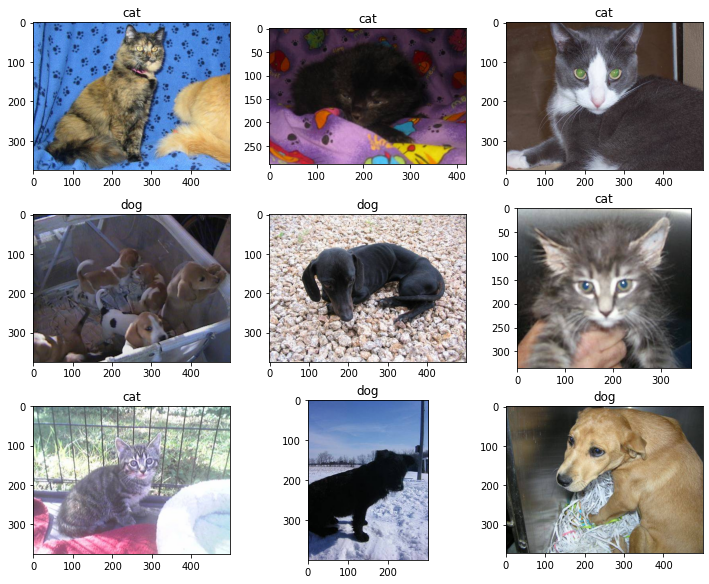

In [39]:
from matplotlib import pyplot
from cv2 import imread
counter = 0 
pyplot.figure(figsize=(12, 10))


for i in x_train.filename.values[:9]:
	# define subplot
	pyplot.subplot(330 + 1 + counter)
	#pyplot.figure(figsize=(10,10))
	# define filename
	filename = '/content/train/' + i
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image[:,:,::-1])  #BGR to RGB
	pyplot.title(i.split('.')[0])
	
	counter += 1
# show the figure
pyplot.show()

In [40]:

from keras.applications import ResNet50,VGG16
import keras.optimizers
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras import layers
from keras.layers import GlobalMaxPooling2D,Dense,Dropout,AveragePooling2D

In [42]:
#!pip install keras-adabound
#from keras_adabound import AdaBound
# Include the epoch in the file name (uses `str.format`)


# Building Resnet-50 model
Imported the pretrained Resnet 50 implementation from keras with imagenet weight. Last two layers of this model are removed. Added a averagepool layer, flatten layer and a dense layer with sigmoid activation for binary classification task. 

Optimizer used is Adam instead of SGD with momentum.

In [48]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape = (224,224,3))
for layer in base_model.layers[:48]:
  layer.trainable = False
for layer in base_model.layers[48:]:
  layer.trainable = True
#base_model.layers[-1].ouput
last = base_model.layers[-1].output
X = AveragePooling2D((7, 7), name='avg_pool')(last)
X = Flatten()(X)
X = Dense(1, activation='sigmoid', name='output')(X)
model = Model(base_model.input, X)

model.compile(loss = 'binary_crossentropy',
              optimizer ='Adam',#AdaBound(lr=1e-3, final_lr=0.1),#optimizers.SGD(lr=1e-4, momentum = 0.9),
              metrics=['accuracy'])
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [49]:
from keras.callbacks import ModelCheckpoint, TensorBoard
! mkdir /content/training
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = '/content/training'

best_model = ModelCheckpoint("/content/training/resnet_best.h5", monitor='val_acc', verbose=0, save_best_only=True)

In [50]:
#create log dir
! rm -rf /content/logs
! mkdir /content/logs

# Training

In [51]:
batch_size=16
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[best_model, TensorBoard(log_dir='/content/logs', histogram_freq=1)])

Epoch 1/20
1094/1094 [==============================] - 328s 300ms/step - loss: 0.6444 - accuracy: 0.6423 - val_loss: 2.4679 - val_accuracy: 0.4988
Epoch 2/20
1094/1094 [==============================] - 325s 297ms/step - loss: 0.5111 - accuracy: 0.7497 - val_loss: 1.0006 - val_accuracy: 0.6351
Epoch 3/20
1094/1094 [==============================] - 325s 297ms/step - loss: 0.4210 - accuracy: 0.8109 - val_loss: 2.0868 - val_accuracy: 0.5468
Epoch 4/20
1094/1094 [==============================] - 326s 298ms/step - loss: 0.3621 - accuracy: 0.8386 - val_loss: 5.6629 - val_accuracy: 0.5069
Epoch 5/20
1094/1094 [==============================] - 325s 297ms/step - loss: 0.3278 - accuracy: 0.8554 - val_loss: 1.1012 - val_accuracy: 0.6737
Epoch 6/20
1094/1094 [==============================] - 324s 296ms/step - loss: 0.3006 - accuracy: 0.8694 - val_loss: 1.5792 - val_accuracy: 0.5949
Epoch 7/20
1094/1094 [==============================] - 324s 296ms/step - loss: 0.2813 - accuracy: 0.8779 - val_

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

In [54]:
#!pip install --ignore-installed tf-nightly
#%load_ext tensorboard
#%tensorboard --logdir /content/logs/fit

# Test data for Kaggle competition

In [55]:
test='test'
id = []
for file in listdir(test):
  category = file.split('.')[0]
  id.append(category)
  

final_test = pd.DataFrame()
#final_test['id']=id
final_test['name']=listdir(test)

final_test.head()

,name
0,4206.jpg
1,5139.jpg
2,10569.jpg
3,7288.jpg
4,8473.jpg


In [56]:
image_size =224
final_test_datagen = ImageDataGenerator(rescale = 1./255 ,              rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

final_test_generator = final_test_datagen.flow_from_dataframe(final_test,
                                'test',
                                x_col = "name",
                                y_col=None,
                                class_mode=None,
                                target_size = (image_size,image_size),
                                batch_size=16)

Found 12500 validated image filenames.


## Predictions for test data

In [58]:
import numpy as np
nb_samples = final_test.shape[0]
predict = model.predict_generator(final_test_generator, steps=np.ceil(nb_samples/batch_size))
final_test['category']=predict
final_test.shape

Instructions for updating:
Please use Model.predict, which supports generators.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f12038f2978>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f12038f2978>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(12500, 2)

In [68]:
final_test.iloc[5]


name        8456.jpg
category    0.225911
Name: 5, dtype: object

# Visualising test data predictions

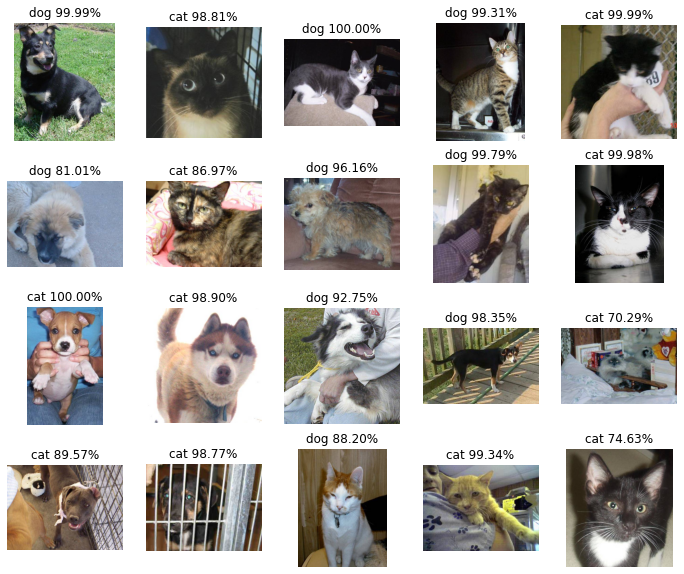

In [73]:
import random
def get_image():
  r = random.randint(1, 12500)
  filename = final_test.iloc[r]['name']
  img = imread('/content/test/'+filename)
  prediction = filename = final_test.iloc[r]['category']
  return img,prediction

plt.figure(figsize=(12, 10))
for i in range(20):
    img,prediction = get_image()
    #prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(img[:,:,::-1]) # convert BGR to RGB

 # Visualize Filters

In [83]:
model.layers

Extracting weights from the first convolution layer.
It has 64 filters of size 7x7

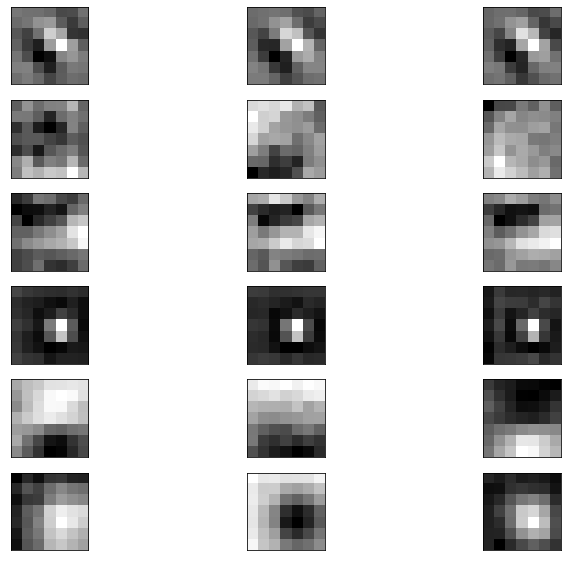

In [82]:

# cannot easily visualize filters lower down

from matplotlib import pyplot
# load the model

# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
pyplot.figure(figsize=(12, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()


In [ ]:
filters

# Feature Maps

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 230, 230, 3)       0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 112, 112, 64)      9472      
Total params: 9,472
Trainable params: 0
Non-trainable params: 9,472
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7f1415c0bdd8>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the

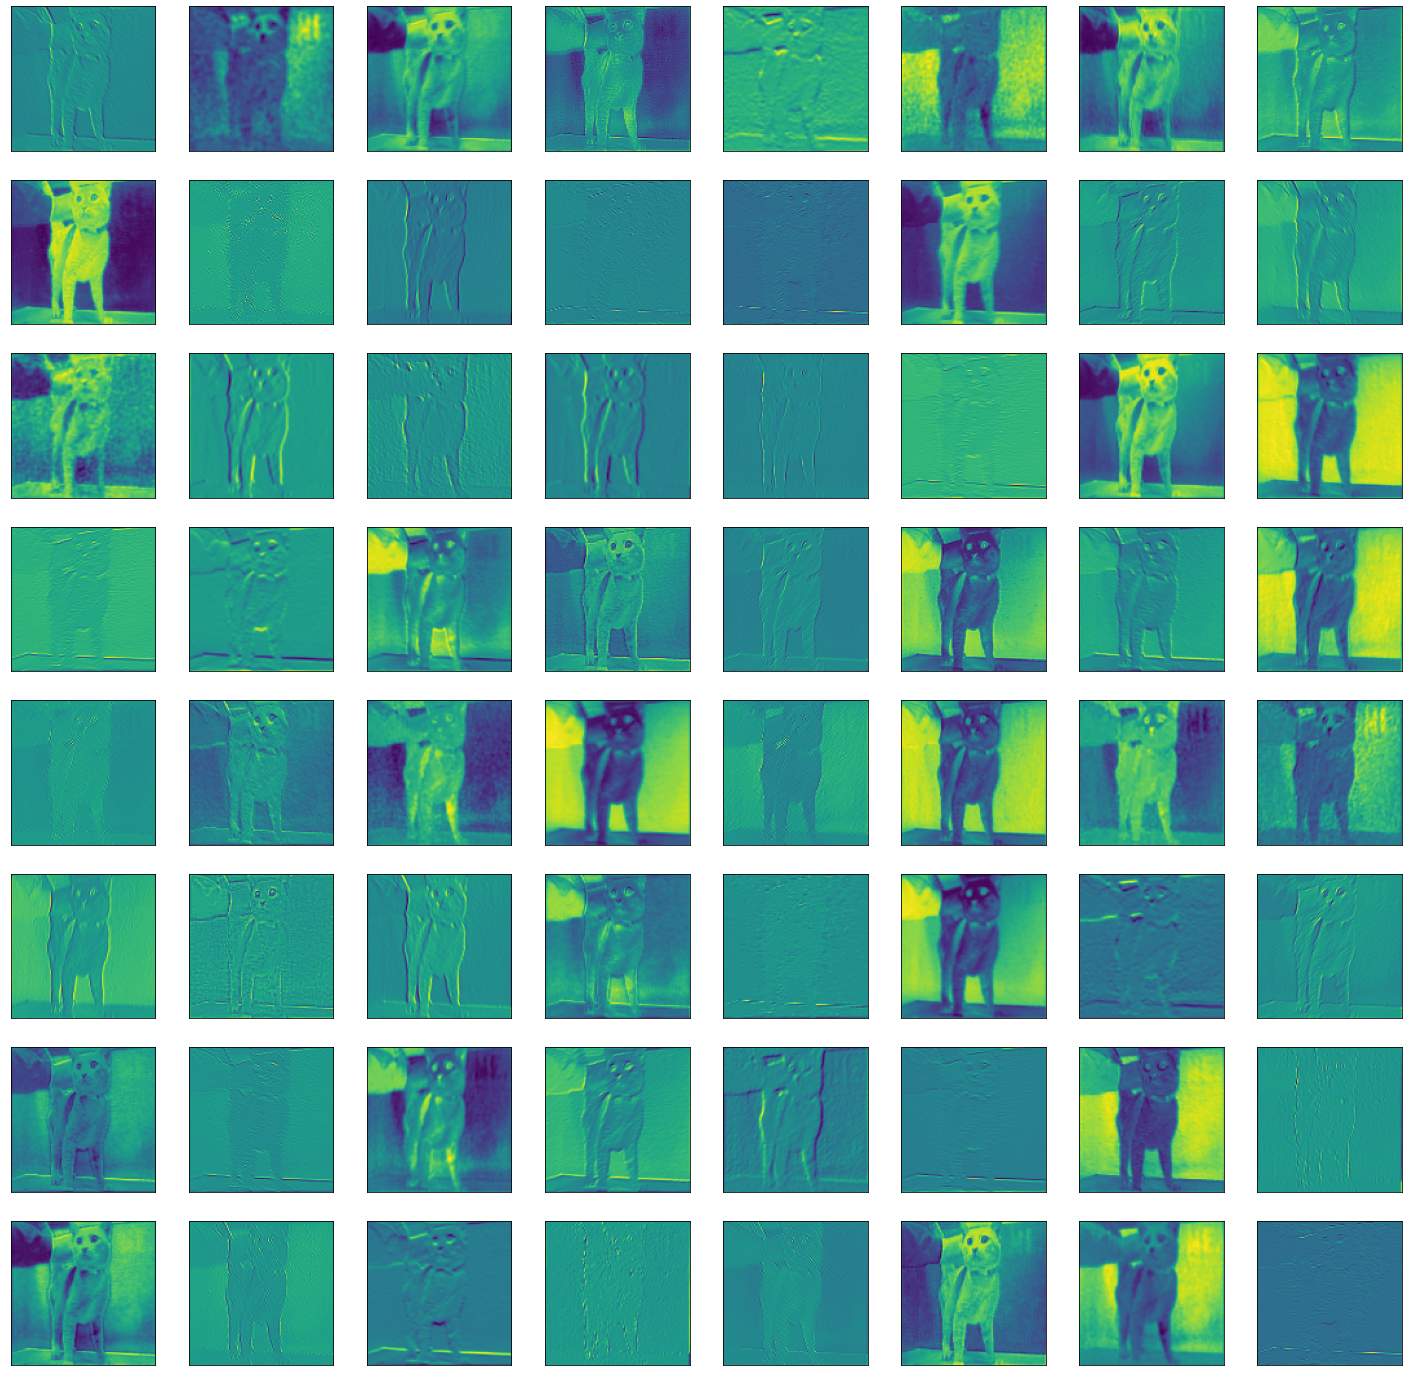

In [94]:

# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model

# redefine model to output right after the first hidden layer
model1 = Model(inputs=model.inputs, outputs=model.layers[2].output)
model1.summary()
# load the image with the required shape
img = load_img('/content/test/5139.jpg', target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model1.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
pyplot.figure(figsize=(25, 25))

for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1])#, cmap='gray')
		ix += 1
# show the figure
pyplot.show()